### In this script we want to quantitatively assess how our model performs on data we collected ourselves using the Empatica wristband. We use the same paramaters as the final XGBoost model which wasa trained on the full JSI dataset, but we train on a smaller set of non-feature expanded data, which is analgous to the data we obtain from the Empatica wristband.

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time
import matplotlib.pyplot as plt

In [2]:
# All subject data included in one .csv file 'pwrtbl_all.csv'
# This data has had outliers removed from sensors and has had smoothing applied
# The person division occur at the following points
# Person A [0:796219] or [:796219]
# Person B [A:1276358]
# Person C [B:1804959]
# Person D [C:2311275]
# Person E [D:2847245]
# Person F [E:3245064]
# Person G [F:3763122]
# Person H [G:4160941]
# Person I [H:4712016]
# Person J [I:5147172] or [I:]

In [3]:
# Load the data
# Loading this 5M line .csv file in with pandas and then converting to numpy is faster than directly loading into numpy with np.genfromtxt()
dataraw = pd.read_csv('tbl_all.csv')

In [4]:
# Exclude all the extraneous data so we just have signals that are easily obtained with the empatica sensor as well
dataraw = dataraw[['ZephyrHR', 'WRIST_accx', 'WRIST_accy', 'WRIST_accz', 'BodyGSR', 'BodyST', 'COSMED']]

In [5]:
# Convert to numpy array
dataraw = dataraw.to_numpy()

In [6]:
# Just splitting the people into separate arrays
divisions = [0, 796219, 1276358, 1804959, 2311275, 2847245, 3245064, 3763122, 4160941, 4712016, 5147172]
data = []
for i in range(0,len(divisions)-1):
    data.append(dataraw[divisions[i]:divisions[i+1],:])

In [7]:
tr = []; ts = []
# Define sets describing who is included in the training and testing sets
fullset = set({0,1,2,3,4,5,6,7,8,9})
trainset = set({0,1,2,3,4,5,6,7})
for i in trainset:
    tr.append(data[i])
# Set difference to find the persons in the test set
for i in fullset - trainset:
    ts.append(data[i])

In [8]:
# Now concatenate the training and testing sets each into a continuous array
tr = np.concatenate(tr, axis = 0)
ts = np.concatenate(ts, axis = 0)

In [9]:
# Break into the X and y arrays for train and test
# Last columns corresponds to the MET value
Xtr = tr[:,:-1]; ytr = tr[:,-1]
Xts = ts[:,:-1]; yts = ts[:,-1]

In [10]:
# Cleaning up all the previous arrays to save memory
del dataraw, data, tr, ts

In [11]:
# Now we will train an XGBoost model
# There are a lot of parameters here, and it is important to understand what each of them does when building our model
# Learning_rate - boosting learning rate, how quickly and strongly the learners are added to the ensemble
# Colsample_bytree - percentage of columns randomly sampled for each tree or estimator
# Max_depth - maximum depth per tree. USed as a way to tune the "weakness" of the learners. In general this value is very low between 1 to 5
# N_estimators - number of estimators or decision trees that comprise the overall ensemble
# Reg_alpha - L1 regularization weight
# Reg_lambda - L2 regularization weight
# Gamma - min split loss, essentially the gain a potnetial split must provide to be considered. This effectively prunes the trees and prevents them from overfitting with meaningless splits
start = time.time()
mdl = xgb.XGBRegressor( \
    learning_rate = 0.05, \
    colsample_bytree = 0.5, \
    max_depth = 5, \
    reg_alpha = 0, \
    reg_lambda = 1, \
    gamma = 50, \
    n_estimators = 200, \
    verbosity = 1 \
        ).fit(Xtr,ytr)
pred = mdl.predict(Xts)
end = time.time()
print('RMSE:',np.sqrt(MSE(yts,pred)),'\tMAE:',MAE(yts,pred), '\tTime: ', (end - start))

/Users/danemerson/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
RMSE: 0.21724020088669366 	MAE: 0.16714952030811678 	Time:  231.0837540626526


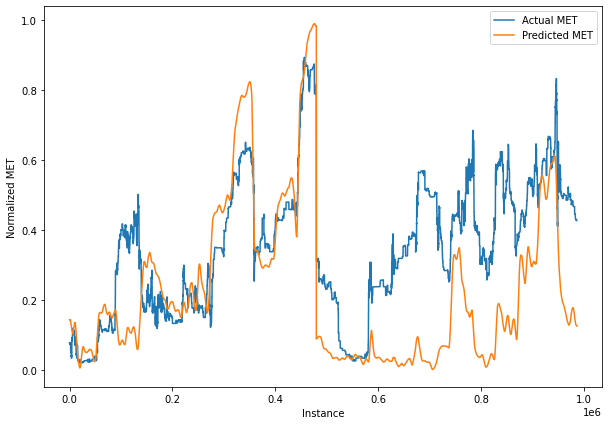

In [12]:
plt.figure(figsize = (10,7))
plt.plot(pred, label = 'Actual MET')
plt.plot(yts, label = 'Predicted MET')
plt.xlabel('Instance'); plt.ylabel('Normalized MET'); plt.legend()
plt.show()

# ROC Curve

In [13]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score

In [14]:
# To construct a ROC curve we need to convert this regression problem into a classification problem. Since we normalized our data, we know it to be centered around 0, thus I will classify MET values above 0 as true, or 1, and MET values below 0 as false, or 0.
yts_class = yts > 0.5
pred_class = pred > 0.5
# yts_class = np.zeros(len(yts))
# pred_class = np.zeros(len(pred))
# divs = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
# for i in range(len(divs)-1):
#     yts_class += i * ((divs[i] < yts) * (yts < divs[i+1]))
#     pred_class += i * ((divs[i] < pred) * (pred < divs[i+1]))

In [15]:
print('Accuracy:', accuracy_score(yts_class, pred_class))
print('Precision:', precision_score(yts_class, pred_class))
print('Recall:', recall_score(yts_class, pred_class))

Accuracy: 0.8619370107003329
Precision: 0.4867586136980494
Recall: 0.8099605106774528


In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.cm as cm

In [17]:
# Plotting confusion matrix
C = confusion_matrix(yts_class, pred_class, labels = [0,1], normalize = None)

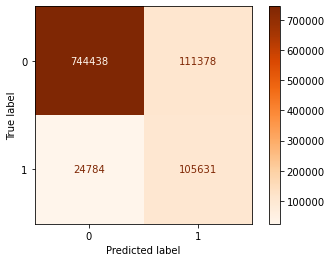

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix = C, display_labels = ['0','1'])
disp.plot(values_format = 'd', cmap = cm.Oranges)
plt.show()

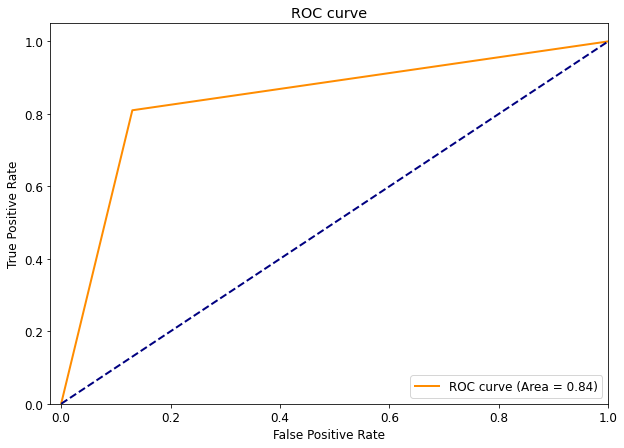

In [19]:
# Compute micro-average ROC curve and ROC area
import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size' : 12}
matplotlib.rc('font', **font)
fpr, tpr, _ = roc_curve(yts_class, pred_class)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (10,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Empatica Data

In [20]:
# Load the empatica data, note there is no ground truth or response variables here, we are just trying to see qualitatively how the model does in predicting on our own data
empaticadata = pd.read_csv('groupdata.csv')
acts = empaticadata[['activity']]
empaticadata = empaticadata[['HR', 'accx', 'accy', 'accz', 'GSR', 'ST']]

In [21]:
# Convert to numpy array
empaticadata = empaticadata.to_numpy()

/Users/danemerson/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


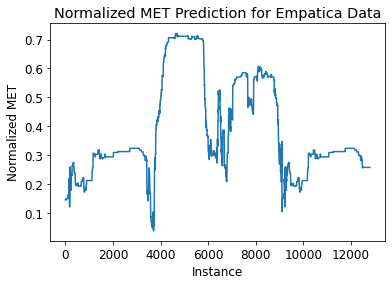

In [22]:
# Predict with the model
pred = mdl.predict(empaticadata)
plt.plot(pred)
plt.xlabel('Instance'); plt.ylabel('Normalized MET'); plt.title('Normalized MET Prediction for Empatica Data')
plt.show()

Here our goal is to see if activities can be easily distinguished. The empatica datset contains 4 activities, lying down, standing, walking, and running. We can see 4 distinct regions of relatively constant MET values, corresponding to the four activities. Thus, while we have no ground truth data, we can quantitatively conclude that the model works reasonably well.